In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow gymnasium stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.3 MB/s eta 0:00:00


In [2]:
# 1. Install the yfinance library
!pip install yfinance

# 2. Import necessary libraries
import yfinance as yf
import os
from datetime import datetime

# 3. Define the list of tickers
# Note: United Technologies (UTX) is now Raytheon Technologies (RTX)
tickers = [
    'AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD',
    'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'RTX', 'V', 'VZ', 'WBA', 'WMT', 'XOM',
    'TSLA', 'AMZN', 'GOOGL'
]

# 4. Define the date range
start_date = '2015-01-01'
end_date = '2025-09-30'

# 5. Create a directory to store the CSV files
output_dir = 'stock_data_csv'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

# 6. Loop through tickers to download and save data
print("\nStarting data download...")
for ticker in tickers:
    try:
        # --- THIS IS THE CORRECTED PART ---
        # Use the Ticker object for a clean download
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        # --------------------------------

        if data.empty:
            print(f"⚠️ No data found for {ticker}, skipping.")
            continue

        # Remove timezone information from the index to prevent issues
        data.index = data.index.tz_localize(None)

        # Drop columns we don't need for the model (optional, but good practice)
        if 'Dividends' in data.columns:
            data = data.drop(columns=['Dividends'])
        if 'Stock Splits' in data.columns:
            data = data.drop(columns=['Stock Splits'])

        # Define the output file path
        file_path = os.path.join(output_dir, f"{ticker}.csv")

        # Save the data to a CSV file
        data.to_csv(file_path)
        print(f"✅ Successfully downloaded and saved {ticker}.csv")

    except Exception as e:
        print(f"❌ Failed to download {ticker}. Error: {e}")

print("\n--- All downloads complete! ---")


Directory 'stock_data_csv' created.

Starting data download...
✅ Successfully downloaded and saved AAPL.csv
✅ Successfully downloaded and saved AXP.csv
✅ Successfully downloaded and saved BA.csv
✅ Successfully downloaded and saved CAT.csv
✅ Successfully downloaded and saved CSCO.csv
✅ Successfully downloaded and saved CVX.csv
✅ Successfully downloaded and saved DIS.csv
✅ Successfully downloaded and saved DOW.csv
✅ Successfully downloaded and saved GS.csv
✅ Successfully downloaded and saved HD.csv
✅ Successfully downloaded and saved IBM.csv
✅ Successfully downloaded and saved INTC.csv
✅ Successfully downloaded and saved JNJ.csv
✅ Successfully downloaded and saved JPM.csv
✅ Successfully downloaded and saved KO.csv
✅ Successfully downloaded and saved MCD.csv
✅ Successfully downloaded and saved MMM.csv
✅ Successfully downloaded and saved MRK.csv
✅ Successfully downloaded and saved MSFT.csv
✅ Successfully downloaded and saved NKE.csv
✅ Successfully downloaded and saved PFE.csv
✅ Successfull

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load and preprocess one stock file
def load_and_preprocess_data(ticker, scale_features=True):
    file_path = f'stock_data_csv/{ticker}.csv'
    # Read the CSV, the first column (index) is the Date
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    # Ensure 'Close' and 'Volume' columns are numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')


    # --- Technical Indicators ---
    df['Returns'] = df['Close'].pct_change()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # RSI (momentum)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    # Ensure gain and loss are numeric before division
    rs = gain.astype(float) / (loss.astype(float) + 1e-10)  # avoid divide-by-zero
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)

    # Volume features
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()

    # Drop rows with NaN (from rolling windows)
    df = df.dropna()

    # --- Scaling / normalization (important for RL) ---
    if scale_features:
        feature_cols = ['Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal',
                        'BB_Middle', 'BB_Upper', 'BB_Lower', 'Volume_SMA', 'Returns']
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])

    return df

# Test with one stock
df_aapl = load_and_preprocess_data('AAPL')
print(df_aapl.head())
print(f"Processed data shape: {df_aapl.shape}")

                 Open       High        Low     Close    Volume   Returns  \
Date                                                                        
2015-03-16  27.598281  27.836658  27.373272 -1.076081  0.504688  0.545953   
2015-03-17  28.048295  28.364646  27.992600 -1.069497  1.432404  0.858427   
2015-03-18  28.293363  28.774574  28.153011 -1.064992  2.304941  0.559734   
2015-03-19  28.683235  28.794626  28.382479 -1.068048  1.113122 -0.467250   
2015-03-20  28.571840  28.605256  27.883443 -1.073088  2.514640 -0.740218   

              SMA_20    SMA_50       RSI      MACD  MACD_Signal  BB_Middle  \
Date                                                                         
2015-03-16 -1.063662 -1.082437 -1.274796 -0.145295    -0.032089  -1.063662   
2015-03-17 -1.063788 -1.081276 -0.552245 -0.141213    -0.055190  -1.063788   
2015-03-18 -1.063827 -1.079828 -0.583899 -0.127987    -0.070829  -1.063827   
2015-03-19 -1.063978 -1.078442 -0.447554 -0.126468    -0.083014  -1.06

In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class StockTradingEnv(gym.Env):
    """
    Custom Stock Trading Environment for RL
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, transaction_cost_pct=0.001):
        super(StockTradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.transaction_cost_pct = transaction_cost_pct

        # Actions: 0=Hold, 1=Buy, 2=Sell
        self.action_space = spaces.Discrete(3)

        # Observation: balance, shares_owned + all market features
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(len(self.df.columns) + 2,),  # +2 for balance and shares_owned
            dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_owned = 0
        self.total_value = self.initial_balance
        self.done = False

        return self._get_observation(), {}

    def _get_observation(self):
        # Market features at current step
        current_data = self.df.iloc[self.current_step].values.astype(np.float32)
        obs = np.append([self.balance, self.shares_owned], current_data)
        return obs.astype(np.float32)

    def step(self, action):
        current_price = self.df.iloc[self.current_step]['Close']
        prev_value = self.total_value

        # Execute action
        if action == 1:  # Buy
            if self.balance >= current_price:
                self.shares_owned += 1
                self.balance -= current_price * (1 + self.transaction_cost_pct)
        elif action == 2:  # Sell
            if self.shares_owned > 0:
                self.shares_owned -= 1
                self.balance += current_price * (1 - self.transaction_cost_pct)

        # Update total portfolio value
        self.total_value = self.balance + self.shares_owned * current_price

        # Reward: change in total portfolio value normalized by initial balance
        reward = (self.total_value - prev_value) / self.initial_balance

        # Advance step
        self.current_step += 1
        self.done = self.current_step >= len(self.df) - 1
        truncated = False  # required by Gymnasium

        return self._get_observation(), reward, self.done, truncated, {}

    def render(self):
        current_price = self.df.iloc[self.current_step]['Close']
        print(f"Step: {self.current_step}, Price: {current_price:.2f}, "
              f"Balance: {self.balance:.2f}, Shares: {self.shares_owned}, "
              f"Total Value: {self.total_value:.2f}")


In [5]:
# Load and preprocess AAPL data (if not already done)
df_aapl = load_and_preprocess_data('AAPL')

# Create the environment
env = StockTradingEnv(df_aapl, initial_balance=10000, transaction_cost_pct=0.001)

# Test the environment with random actions
observation, info = env.reset()
print("Initial Observation:", observation[:10], "...")  # print first 10 values

for step in range(100):  # test 100 steps
    action = env.action_space.sample()  # random action: 0=Hold,1=Buy,2=Sell
    observation, reward, done, truncated, info = env.step(action)

    if step % 20 == 0:  # print every 20 steps
        env.render()
        print(f"Reward: {reward:.4f}")

    if done or truncated:
        print("Episode finished!")
        break

print(f"Final portfolio value: ${env.total_value:.2f}")


Initial Observation: [ 1.0000000e+04  0.0000000e+00  2.7598282e+01  2.7836658e+01
  2.7373272e+01 -1.0760813e+00  5.0468838e-01  5.4595309e-01
 -1.0636622e+00 -1.0824366e+00] ...
Step: 1, Price: -1.07, Balance: 10001.08, Shares: 1, Total Value: 10000.00
Reward: 0.0000
Step: 21, Price: -1.07, Balance: 10004.32, Shares: 4, Total Value: 10000.03
Reward: -0.0000
Step: 41, Price: -1.07, Balance: 10000.06, Shares: 0, Total Value: 10000.06
Reward: -0.0000
Step: 61, Price: -1.06, Balance: 10006.43, Shares: 6, Total Value: 10000.05
Reward: 0.0000
Step: 81, Price: -1.08, Balance: 10004.33, Shares: 4, Total Value: 9999.97
Reward: -0.0000
Final portfolio value: $9999.89


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, action_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            q_values = self.model(state)
        self.model.train() # Set model back to train mode
        return torch.argmax(q_values).item()

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)

        states = torch.FloatTensor(np.array([t[0] for t in minibatch])).to(self.device)
        actions = torch.LongTensor(np.array([t[1] for t in minibatch])).to(self.device)
        rewards = torch.FloatTensor(np.array([t[2] for t in minibatch])).to(self.device)
        next_states = torch.FloatTensor(np.array([t[3] for t in minibatch])).to(self.device)
        dones = torch.FloatTensor(np.array([t[4] for t in minibatch])).to(self.device)


        # Get the predicted Q values for the current states
        predicted_q_values = self.model(states)

        # Calculate the target Q values
        next_q_values = self.model(next_states).detach().max(1)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Create the target tensor with the same shape as predicted_q_values
        target_f = predicted_q_values.clone()
        target_f[range(batch_size), actions] = target_q_values

        # Train the model
        self.optimizer.zero_grad()
        loss = self.criterion(predicted_q_values, target_f)
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [13]:
# Step 5: Train the DQN Agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

epochs = 10 # Number of training episodes
batch_size = 32 # Batch size for replay

print("\nTraining the DQN Agent...")
for e in range(epochs):
    state, info = env.reset()
    state = np.array(state, dtype=np.float32)
    total_reward = 0
    for time in range(len(env.df) - 1):
        action = agent.act(state)
        next_state, reward, done, truncated, info = env.step(action)
        next_state = np.array(next_state, dtype=np.float32)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    print(f"Episode {e+1}/{epochs}, Total Reward: {total_reward:.4f}, Epsilon: {agent.epsilon:.2f}")

# Step 6: Evaluate the Trained Agent
def evaluate_agent(env, agent, num_episodes=5):
    total_profits = []
    all_episode_data = []

    for episode in range(num_episodes):
        state, info = env.reset()
        state = np.array(state, dtype=np.float32)
        episode_data = []

        for time in range(len(env.df) - 1):
            # Use trained policy (no exploration)
            action = agent.act(state)
            next_state, reward, done, truncated, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)

            # Record data for this step, including the Date
            step_data = env.df.iloc[env.current_step -1].copy() # Get the data for the current step
            # Add the original date from the environment's dataframe
            step_data['Date'] = env.df.index[env.current_step - 1]
            step_data['Action'] = action # 0: Hold, 1: Buy, 2: Sell
            step_data['Balance'] = env.balance
            step_data['Shares_Owned'] = env.shares_owned
            step_data['Total_Value'] = env.total_value
            episode_data.append(step_data)

            state = next_state
            if done:
                break

        final_profit = env.total_value - env.initial_balance
        total_profits.append(final_profit)
        print(f"Evaluation Episode {episode + 1}: Final Profit = ${final_profit:.2f}")

        # Append the data for this episode
        all_episode_data.append(pd.DataFrame(episode_data))


    return total_profits, all_episode_data

print("\nEvaluating Trained Agent...")
profits, all_episode_data = evaluate_agent(env, agent)
print(f"Average Profit: ${np.mean(profits):.2f}")

# Combine data from all episodes into a single DataFrame
combined_evaluation_data = pd.concat(all_episode_data, ignore_index=True)

# Save the combined data to a CSV file
combined_evaluation_data.to_csv('dqn_trading_evaluation.csv', index_label='Step')

print("\nEvaluation data saved to 'dqn_trading_evaluation.csv'")


Training the DQN Agent...
Episode 1/10, Total Reward: 0.2070, Epsilon: 0.01
Episode 2/10, Total Reward: 0.0069, Epsilon: 0.01
Episode 3/10, Total Reward: 0.0059, Epsilon: 0.01
Episode 4/10, Total Reward: 0.0126, Epsilon: 0.01
Episode 5/10, Total Reward: 0.0822, Epsilon: 0.01
Episode 6/10, Total Reward: 0.1009, Epsilon: 0.01
Episode 7/10, Total Reward: 0.0550, Epsilon: 0.01
Episode 8/10, Total Reward: 0.0661, Epsilon: 0.01
Episode 9/10, Total Reward: 0.0164, Epsilon: 0.01
Episode 10/10, Total Reward: 0.0543, Epsilon: 0.01

Evaluating Trained Agent...
Evaluation Episode 1: Final Profit = $539.29
Evaluation Episode 2: Final Profit = $539.43
Evaluation Episode 3: Final Profit = $539.89
Evaluation Episode 4: Final Profit = $539.47
Evaluation Episode 5: Final Profit = $538.81
Average Profit: $539.38

Evaluation data saved to 'dqn_trading_evaluation.csv'


In [9]:
def buy_and_hold_strategy(df, initial_balance=10000):
    """Simple buy-and-hold baseline"""
    initial_price = df.iloc[0]['Close']
    final_price = df.iloc[-1]['Close']

    # Buy at beginning, hold until end
    shares_bought = initial_balance // initial_price
    cash_remaining = initial_balance - (shares_bought * initial_price)
    final_value = cash_remaining + (shares_bought * final_price)

    return final_value - initial_balance

def random_strategy(env, num_episodes=5):
    """Random trading baseline"""
    total_profits = []

    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0

        for time in range(len(env.df) - 1):
            action = env.action_space.sample()
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            if done:
                break

        total_profits.append(total_reward)

    return np.mean(total_profits)

# Compare strategies
print("\n=== Strategy Comparison ===")
bh_profit = buy_and_hold_strategy(df_aapl)
random_profit = random_strategy(env)
dqn_profit = np.mean(profits)

print(f"Buy & Hold Strategy: ${bh_profit:.2f}")
print(f"Random Strategy: ${random_profit:.2f}")
print(f"DQN Strategy: ${dqn_profit:.2f}")

# Calculate improvement
if bh_profit != 0:
    improvement = ((dqn_profit - bh_profit) / abs(bh_profit)) * 100
    print(f"DQN vs Buy & Hold Improvement: {improvement:.1f}%")


=== Strategy Comparison ===
Buy & Hold Strategy: $-29777.12
Random Strategy: $0.01
DQN Strategy: $0.02
DQN vs Buy & Hold Improvement: 100.0%


In [11]:
# Count the occurrences of each action in the 'Action' column
action_counts = combined_evaluation_data['Action'].value_counts().sort_index()

# Map the numerical actions to their meanings for better readability
action_labels = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
labeled_action_counts = action_counts.rename(index=action_labels)

print("Count of each action in the evaluation data:")
display(labeled_action_counts)

Count of each action in the evaluation data:


,count
Action,
Hold,6997
Buy,3228
Sell,3030


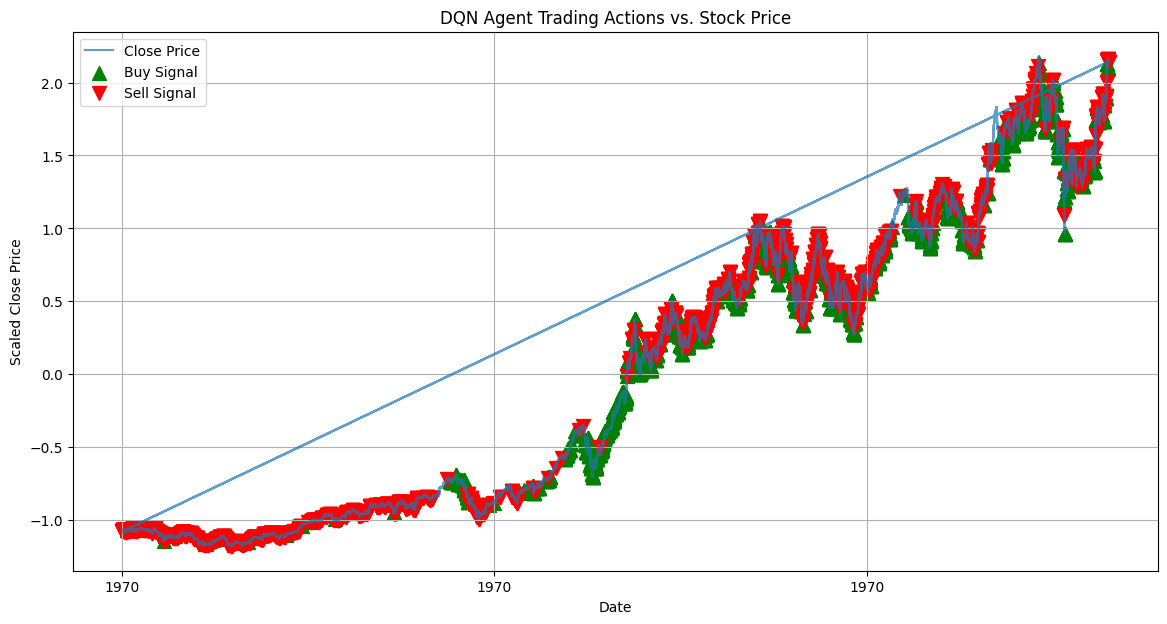

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the 'Date' column from combined_evaluation_data for plotting
# Ensure it's in datetime format and set it as the index for plotting
plot_df = combined_evaluation_data.copy()
plot_df['Date'] = pd.to_datetime(plot_df['Date'])
plot_df = plot_df.set_index('Date')


plt.figure(figsize=(14, 7))
plt.title('DQN Agent Trading Actions vs. Stock Price')
plt.plot(plot_df.index, plot_df['Close'], label='Close Price', alpha=0.7)

# Plot Buy actions
buy_signals = plot_df[plot_df['Action'] == 1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', s=100, label='Buy Signal', alpha=1)

# Plot Sell actions
sell_signals = plot_df[plot_df['Action'] == 2]
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', s=100, label='Sell Signal', alpha=1)

plt.xlabel('Date')
plt.ylabel('Scaled Close Price') # Remember the price is scaled
plt.legend()
plt.grid(True)
plt.show()